# Proyecto 14

## Descripción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

### Instrucciones del proyecto

1. Carga los datos.
2. Preprocesa los datos, si es necesario.
3. Realiza un análisis exploratorio de datos y haz tu conclusión sobre el desequilibrio de clases.
4. Realiza el preprocesamiento de datos para el modelado.
5. Entrena al menos tres modelos diferentes para el conjunto de datos de entrenamiento.
6. Prueba los modelos para el conjunto de datos de prueba.
7. Escribe algunas reseñas y clasifícalas con todos los modelos.
8. Busca las diferencias entre los resultados de las pruebas de los modelos en los dos puntos anteriores. Intenta explicarlas.
9. Muestra tus hallazgos.

### Descripción de los datos

El dataset está almacenado en el archivo /datasets/imdb_reviews.tsv. descargar dataset.

| Columna           | Descripción   |
|-------------------|---------------|
| tconst            | Codificación de la pelicula o serie |
| title_type        | Tipo (Serie o Pelicula) |
| primary_title     | Titulo |
| original_title    | Nombre original |
| start_year        | Año de inicio o estreno |
| end_year          | Año de finalizacion |
| runtime_minutes   | Duración |
| is_adult          | Indicador si es para adultos o no (bool 0 o 1) |
| genres            | Generos |
| average_rating    | Rating promedio |
| votes             | Cantidad de votos |
| review            | Reseñas |
| rating            | Rating |
| sp                | Tipo de reseña (positiva o negativa) |
| pos               | Indicacion de sp en bool (1 o 0) |
| ds_part           | Indicador si es conjunto de entrenamiento o prueba (train-test)|
| idx               | Indexacion |

En este analisis solo se considerarán solo las reseñan para el conjunto de entrenamiento, puesto que este proyecto analiza el aprendizaje en textos, por otro lado este dqataset ya viene con la separación para el conjunto de pruebas y entrenamiento, finalmente se utilizará pos como objetivo para los modelos.

In [1]:
# Bibliotecas estandar
import os
import re
import time

# Bibliotecas de terceros
import requests
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm


d:\projects\TripleTen\sprint_14\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [3]:
# Habilitar progress_apply
tqdm.pandas()

In [4]:
# Constantes
STATE = 31415

## Carga de datos

In [5]:
# Funcion para descargar dataset
def download_and_save(url: str, filename: str=None) -> None:
    '''Retorna nada
    Función que descarga los dataset desde los links entregados, y los guardará en la carpeta datasets, si esta no existe se creará en la raiz
    :param url: string
    :param filename (optional): string
    :return:Nada
    '''

    if not filename:
        start_index = url.rfind('/') + 1
        filename = url[start_index:].lower()

    directory = 'datasets'
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    full_path = os.path.join(directory,filename)
 
    if os.path.exists(full_path):
        print(f"El archivo {filename} ya existe en {directory}. Descarga cancelada.")
        return
    
    response = requests.get(url)
    if response.status_code == 200:
        
        with open(full_path, 'wb') as file:
            file.write(response.content)
        print(f'Archivos guardado en: {full_path}')
    else:
        print('Error al descargar el archivo')

In [6]:
# URL del dataset
url_dataset = 'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv'

In [7]:
# Ejecutar funcion de descarga
download_and_save(url_dataset)

El archivo imdb_reviews.tsv ya existe en datasets. Descarga cancelada.


In [8]:
# Carga de DataFrame
df = pd.read_csv('./datasets/imdb_reviews.tsv', sep='\t')

In [9]:
# Sample
df.sample(5, random_state=STATE)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
19674,tt0446725,movie,Kissing on the Mouth,Kissing on the Mouth,2005,\N,78,0,"Drama,Romance",4.6,595.0,I admire 'Kissing on the Mouth' for its frankn...,2,neg,0,train,8557
38872,tt0191242,movie,The Last Stop,The Last Stop,2000,\N,94,0,Thriller,5.2,571.0,Being a self confessed slasher addict means th...,7,pos,1,test,6032
2946,tt0149698,movie,Appetite,Appetite,1998,\N,97,0,"Mystery,Thriller",4.2,257.0,I can't believe that I actually sat thru this ...,2,neg,0,test,4321
21412,tt0085050,tvSeries,Mama's Family,Mama's Family,1983,1990,30,0,Comedy,7.3,4303.0,"Very simply, they are all the syndicated episo...",1,neg,0,test,7331
251,tt0062622,movie,2001: A Space Odyssey,2001: A Space Odyssey,1968,\N,149,0,"Adventure,Sci-Fi",8.3,582152.0,"2001 is one of those movies where, if you don'...",1,neg,0,test,590


## Limpieza y preparación de datos

In [10]:
# Información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

Si bien para el entrenamiento de los modelos se utilizará solo `review`, `ds_part` y `pos`, algunas otras columnas serán utilizadas en el analisis exploratorio, aunque se puede ver que no es necesario preparar los datos, ya que solo existen unos pocos datos nulos que no son relevantes para la parte importante del proyecto.

In [11]:
# Eliminar filas con reseñas duplicadas
df = df.drop_duplicates(subset='review')

df['review'].duplicated().sum()

0

## DEA

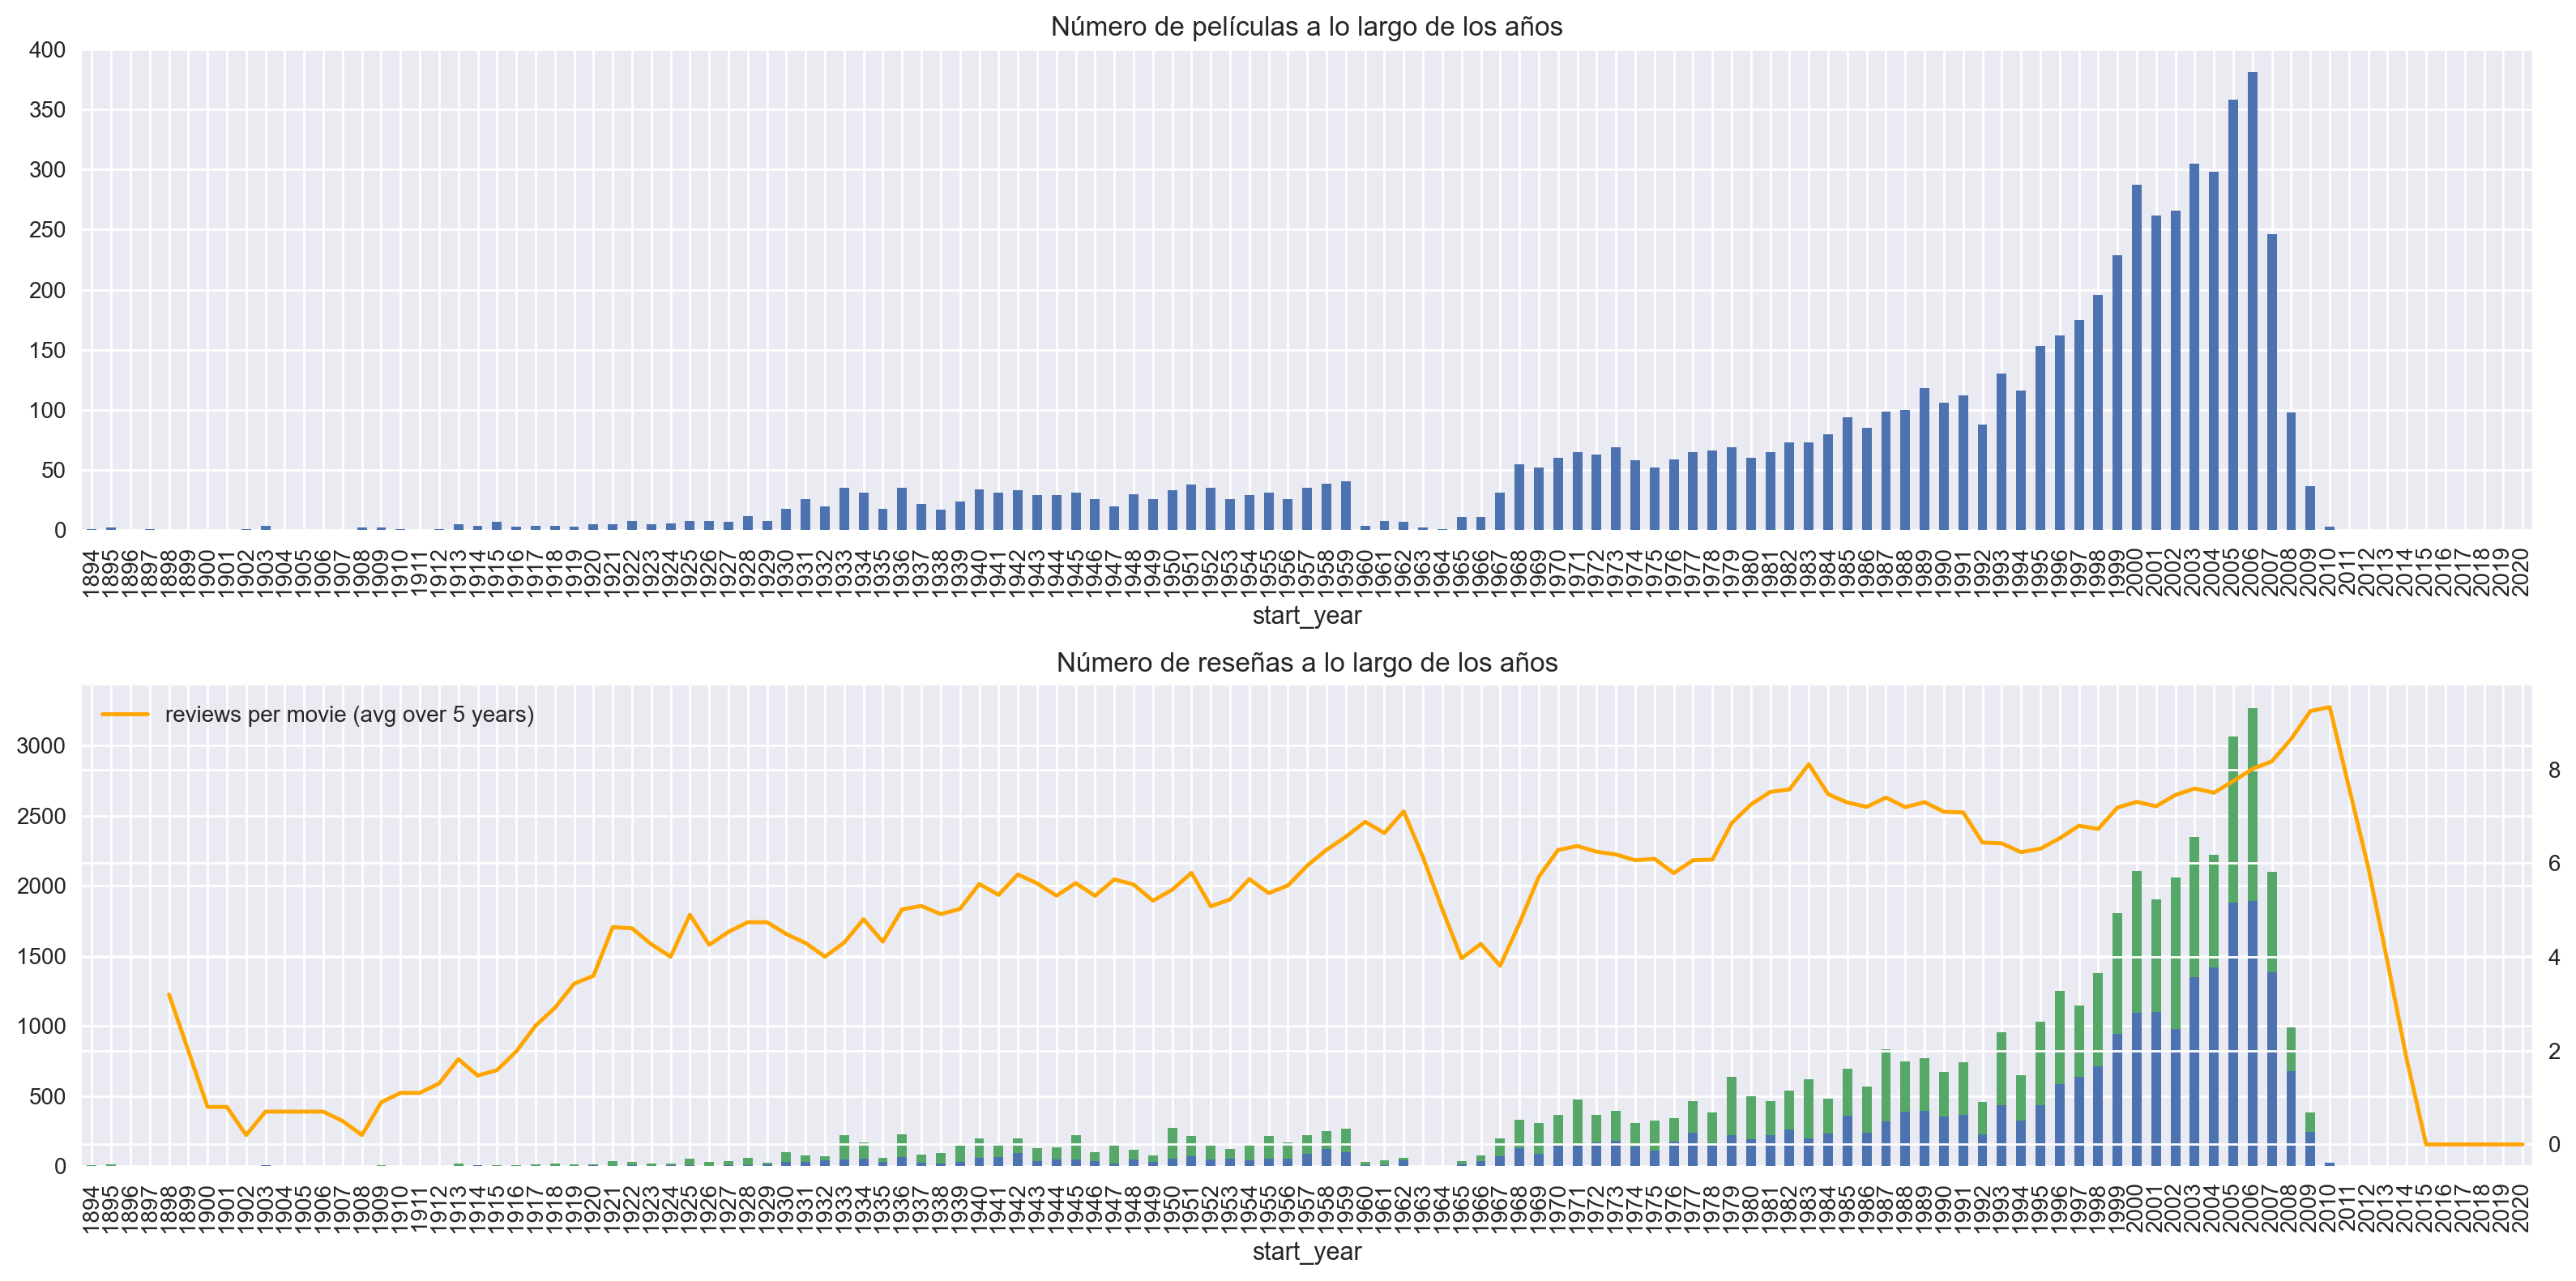

In [12]:
# Analisis de peliculas a lo largo de los años
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Plot 1
ax = axs[0]

# Numero de peliculas (sin repetirse debido a las reseñas) por año
dft1 = df[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

# Plot 2
ax = axs[1]

# Numero de reseñas por año
dft2 = df.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

# Se calcula el numero de reseñar por pelicula
dft3 = (dft2.sum(axis=1) / dft1).fillna(0)
axt = ax.twinx()
# Se calcula la media movil en periodos de 5 años
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Del analisis podemos notar el avance de la industria cinematografica, con un aumento gradual (a excepcion del periodo entre 1960 y 1966) para posteriormente tener un aumento mas agresivo a partir de 1980, hasta el 2011, hasta donde se tienen los datos del dataset. Por otro lado la media movil de reseñas por peliculas se mantiene relativamente constante en el tiempo.

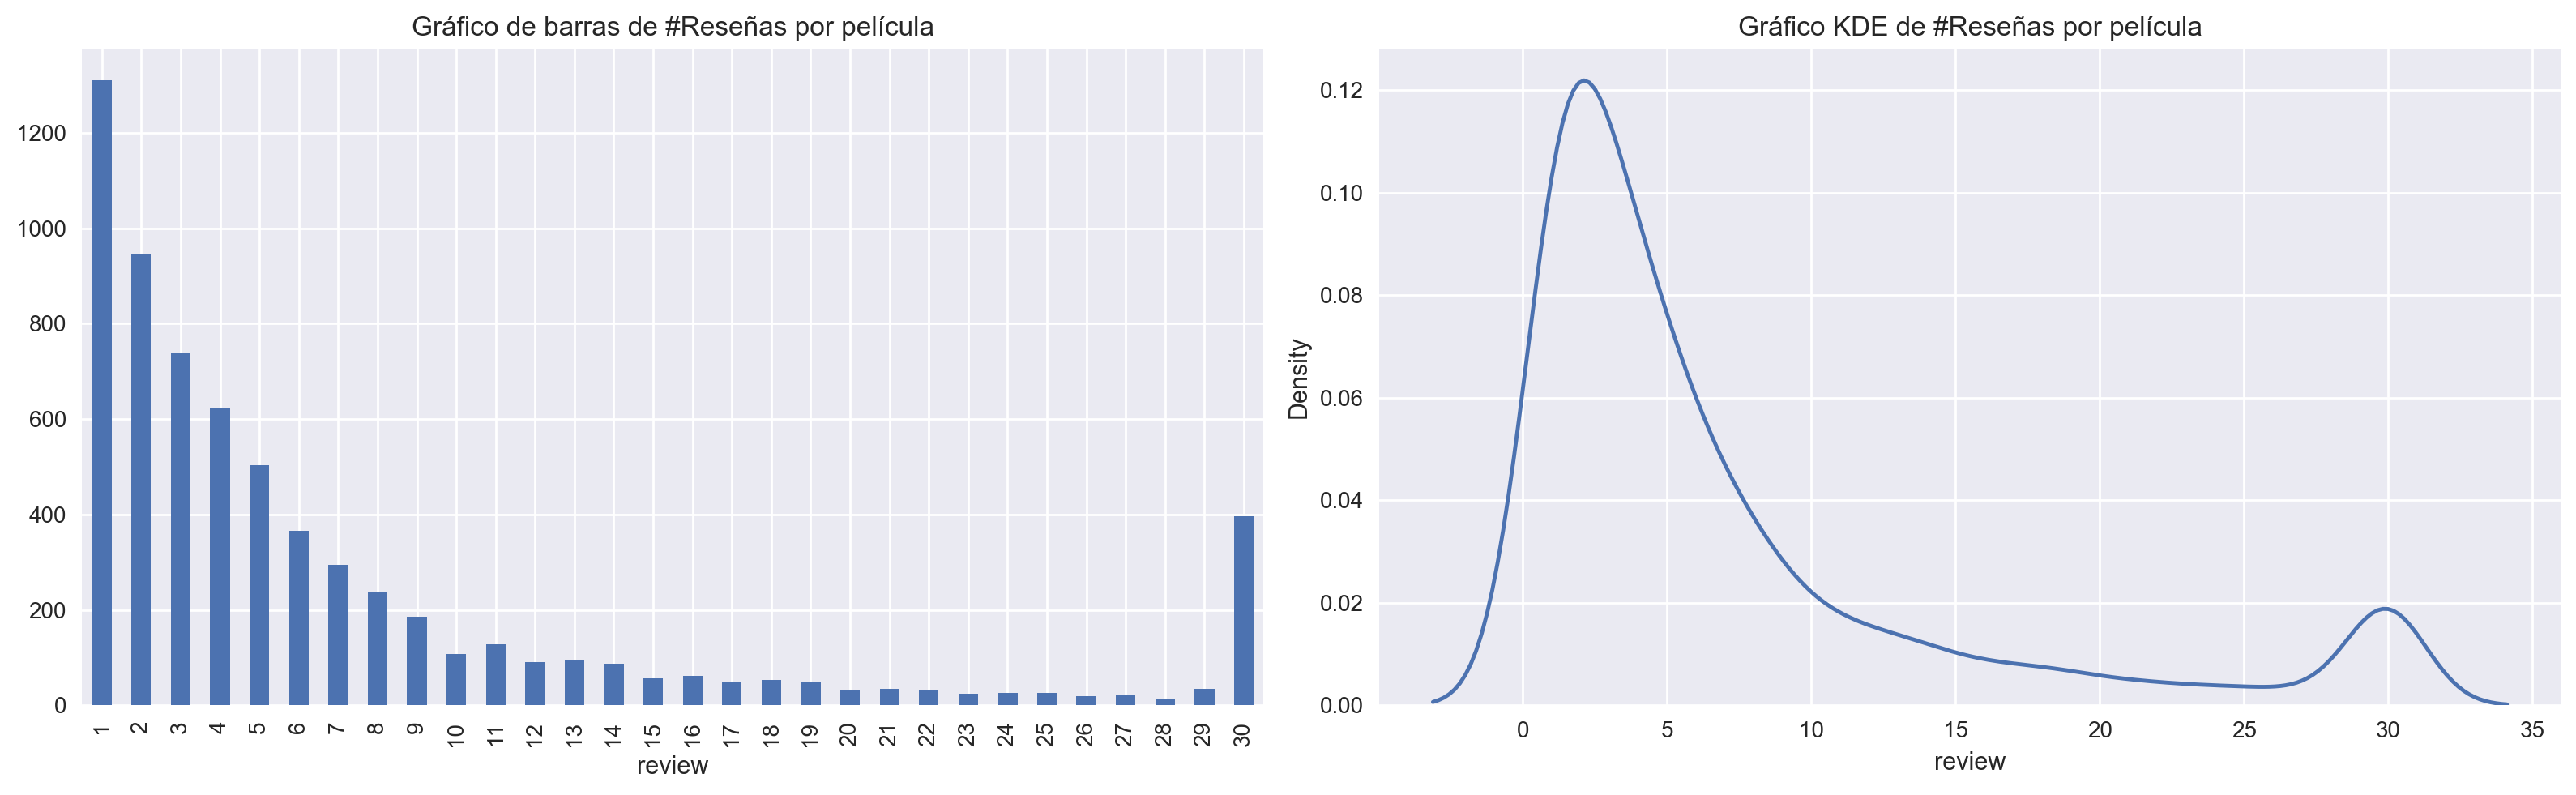

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

#Plot 1
ax = axs[0]

dft = df.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

# Plot 2
ax = axs[1]
dft = df.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax) # Grafico de densidad
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Las peliculas en general suelen tener entre 1 y 10 reseñas, luego el numero de peliculas por cantidad de reseña baja, aunque a existe un gran numero de peliculas que posee 30 o mas reseñas, las cuales deben referirse a las peliculas mas taquilleras y nuevas.

In [14]:
# Numero de reseñas positivas y negativas (0 negativa, 1 positiva)
df['pos'].value_counts()

pos
0    23680
1    23560
Name: count, dtype: int64

Este dataset se encuentra balanceado, teniendo un numero muy similar de clasificacion (target) positivo y negativo.

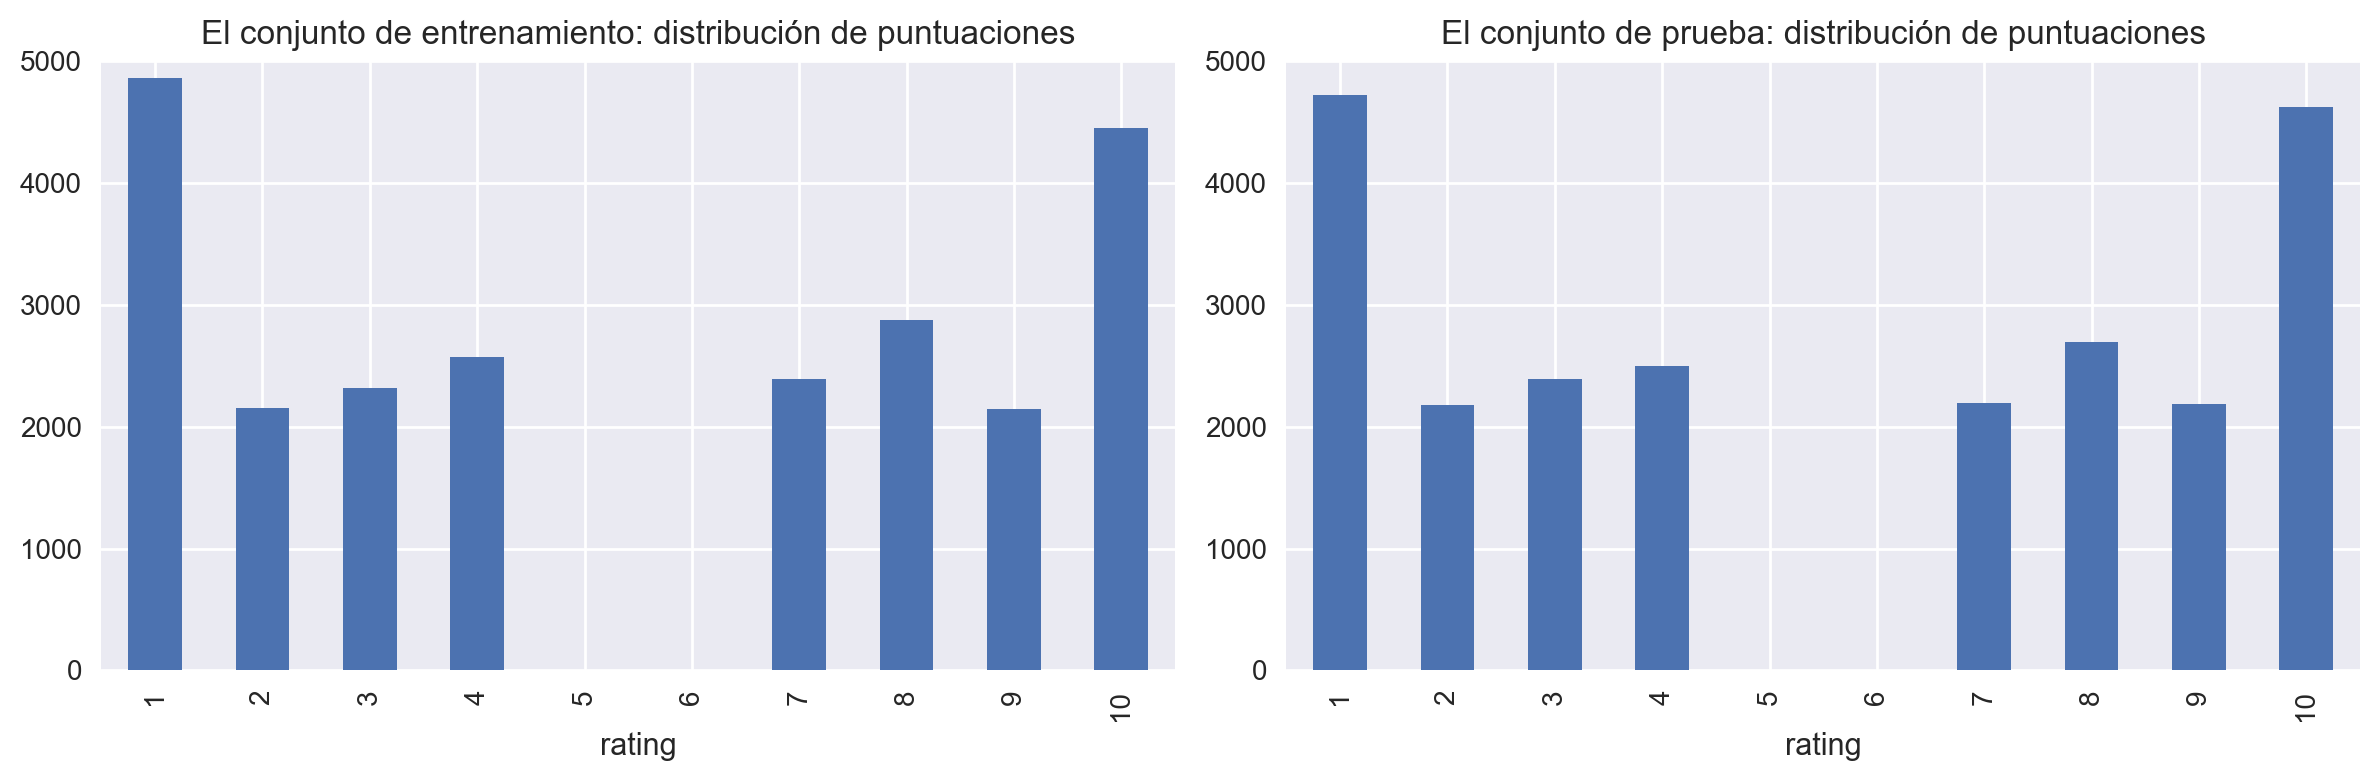

In [15]:
# Rating de peliculas en conjunto de entrenamiento y de pruebas
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

En ambos conjuntos las puntuaciones de ranking se comportan de manera similar, en el cual el publico tiende a polarizar sus opiniones, dandole muy buena puntuacion o muy mala.

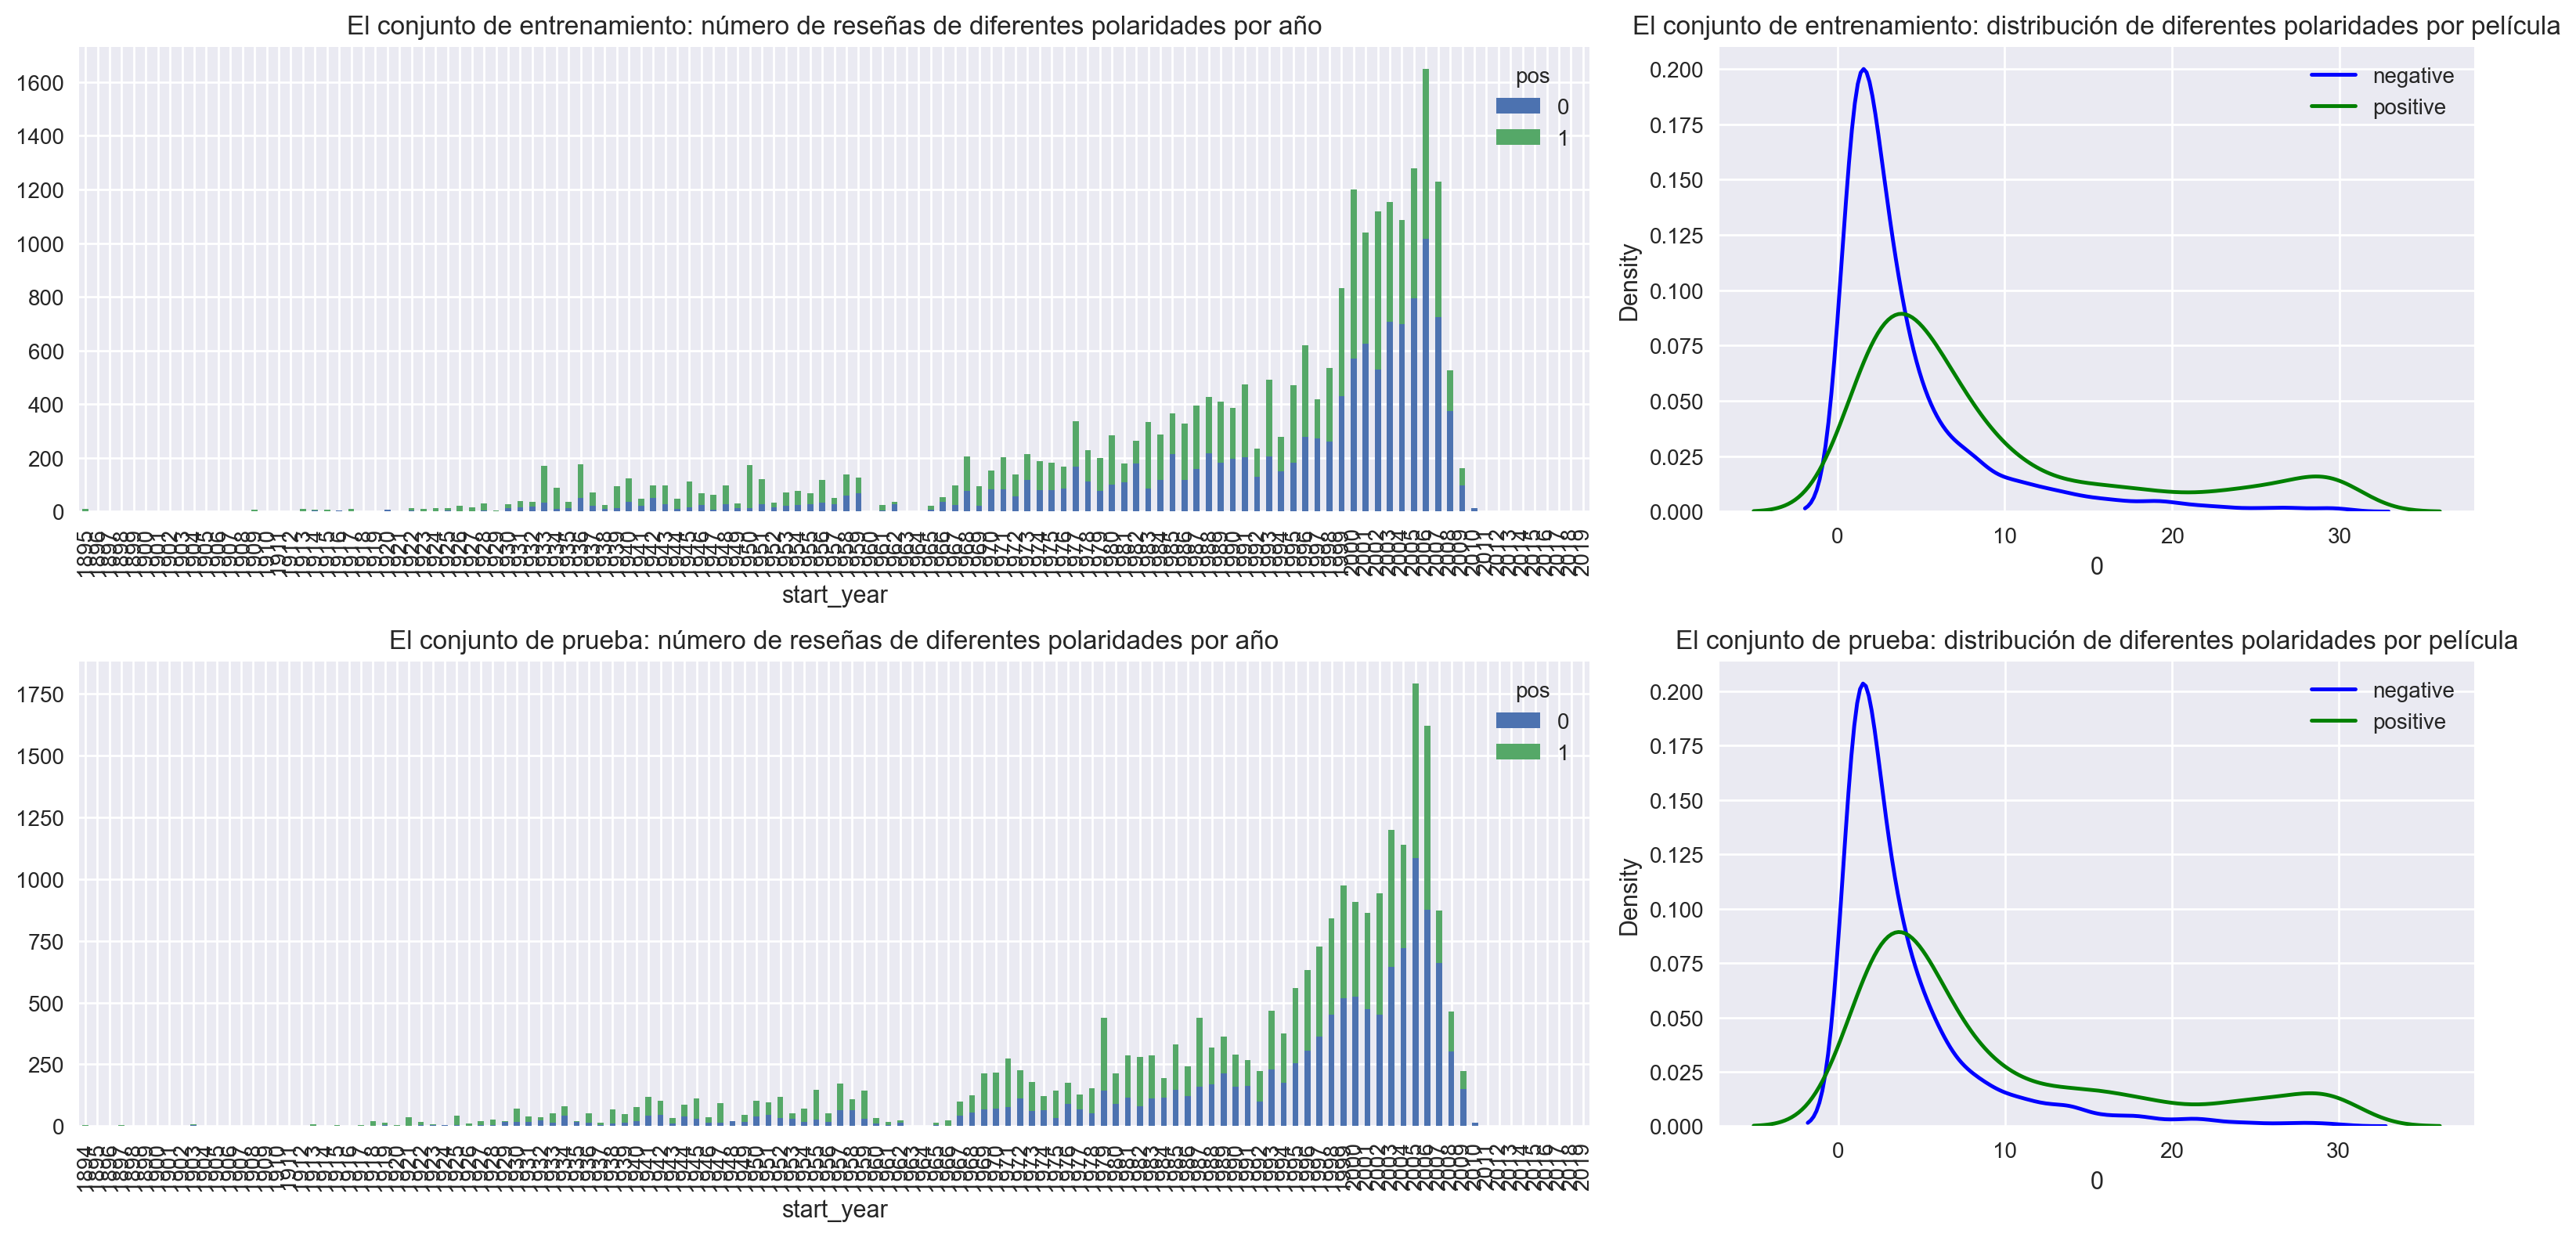

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Se puede notar que cuando habia menor numero de peliculas, estas solian ser mejor criticadas, teniendo mayor numero de reseñas positivas, en la actualidad, debido a la gran cantidad de oferta, no toda debe ser de gran calidad,  teniendo muchas mas peliculas que pueden no gustar al publico.

Si bien el numero de comentarios positivos y negativos es muy similar, el comportamiento de este difiere, ya que los comentarios negativos suelen concentrarse en un menor numero de reseñas en muchas peliculas, mientras que los comentarios negativo se distribuyen en mayor manera en peliculas con con varias.

## Preprocesamiento de datos para modelado

In [17]:
#Importe de librerias necesarias
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

import nltk
from nltk.corpus import stopwords

In [18]:
# Descarga y asignacion de palabras vacias
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaqu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Asignacion de librearia para preparacion de textos
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [20]:
# Funcion para rutina de evaluacion de modelos
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1: Obtiene F1 para umbrales desde 0 a 1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC: Obtiene valores de curva ROC (Falsos Positivos, Verdaderos Positivos y umbrales). Y area bajo la curva.
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC: Obtiene valores de curva PR (precision, recall y umbrales). Y precision promedio.
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        # Elije color dependiendo del tipo de conjunto
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores) # Argumento de F1 maximo
        # Grafico
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # Establece puntos a distintos umbrales    
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return df_eval_stats

In [21]:
# Funcion de limpieza
def clear_text(text:str) -> str:
    '''
    Limpia un texto de simbolos que no sean letras, puntos o apostrofes
    '''
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    text = text.split()
    return " ".join(text)


In [22]:
# Funcion de lematizacion
def lemmatize(text):
    doc = nlp(text.lower())  
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
        
    return ' '.join(lemmas)

In [23]:
# Normalizacion de datos
df['review_norm'] = df['review'].apply(lambda text: clear_text(text.lower()))
df['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

In [24]:
# lematiza datos
df['review_lemma'] = df['review'].apply(lambda text: lemmatize(clear_text(text.lower())))
df['review_lemma'].head()

0    the pakage imply that warren beatty and goldie...
1    how the hell do they get this make present its...
2    there be no real story the film seem more like...
3    um a serious film about troubled teen in singa...
4    I be totally agree with garryjohal from singap...
Name: review_lemma, dtype: object

In [25]:
# Obtención conjunto de entrenamiento y pruebas
df_reviews_train = df.query('ds_part == "train"').copy()
df_reviews_test = df.query('ds_part == "test"').copy()

target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23757, 19)
(23483, 19)


## Prueba de modelos

In [26]:
# Funcion para vectorizado de datos
def vectorize_data(df_train, df_test, params_vectorizer={}):
    count_tf_idf_1 = TfidfVectorizer(**params_vectorizer)
    tf_idf_train_1 = count_tf_idf_1.fit_transform(df_train)
    tf_idf_test_1 = count_tf_idf_1.transform(df_test)

    return tf_idf_train_1, tf_idf_test_1

In [27]:
# Funcion para agregar df de resultados por modelo
def transform_df_model(df, model_name):
    df = df.T.reset_index()
    df['model'] = model_name
    return df


In [28]:
df_models = pd.DataFrame()

### 1. Modelo Dummy - Constante

Es un modelo base que predice utilizando estrategias simples como la mayoría de clases o estrategias aleatorias. Se utiliza como punto de referencia para comparar con otros modelos más complejos.

In [29]:
# Importacion de libreria
from sklearn.dummy import DummyClassifier

In [30]:
# Vectorizacion
features_train_1, features_test_1 = vectorize_data(df_reviews_train['review_norm'],df_reviews_test['review_norm'])

In [31]:
# Entrenamiento de modelo
model_1 = DummyClassifier(strategy='uniform')
model_1.fit(features_train_1, target_train)

DummyClassifier(strategy='uniform')

          train  test
Accuracy   0.49   0.5
F1         0.49   0.5
APS        0.50   0.5
ROC AUC    0.50   0.5


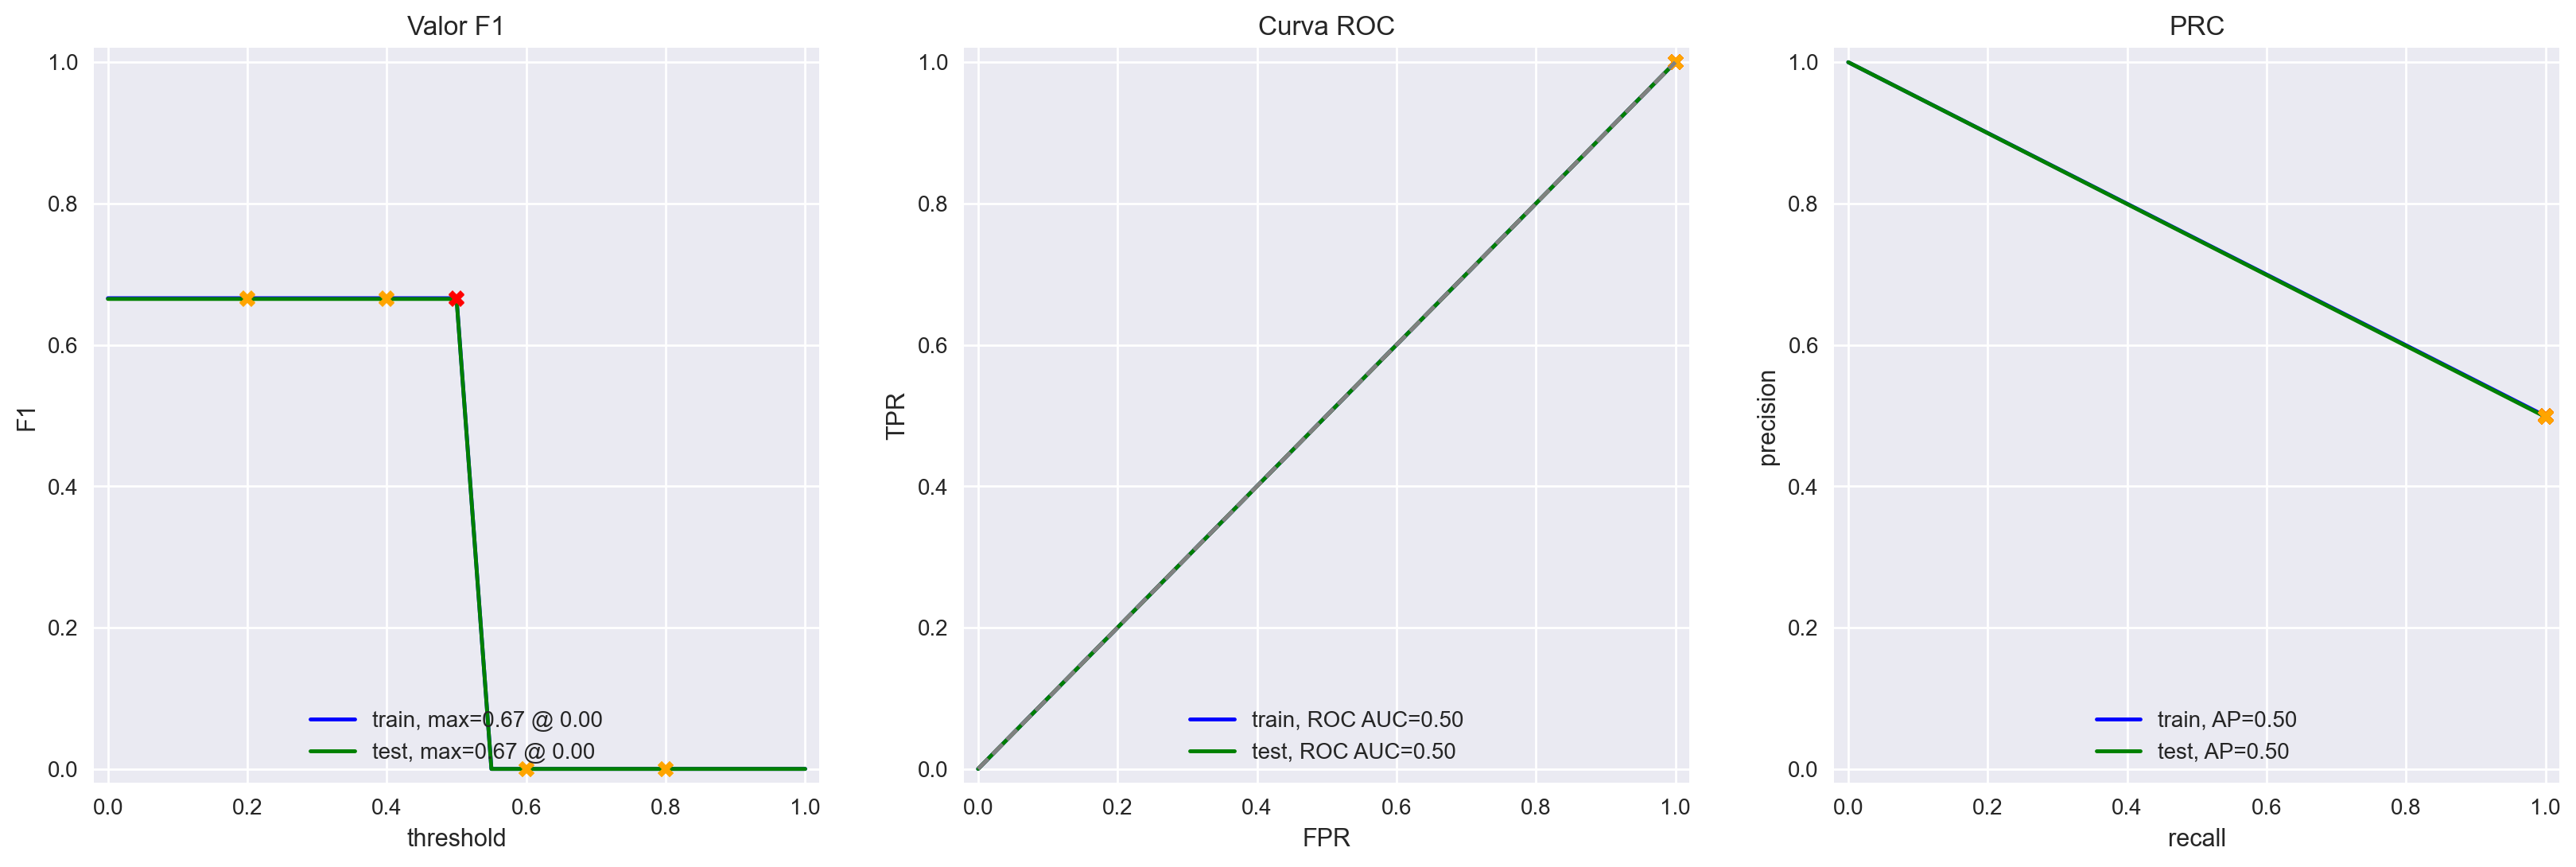

In [32]:
df_model_1 = evaluate_model(model_1, features_train_1, target_train, features_test_1, target_test)

In [33]:
# guardar datos 
df_models = pd.concat([df_models, transform_df_model(df_model_1, 'model_1')]).reset_index(drop=True)
df_models

,index,Accuracy,F1,APS,ROC AUC,model
0,train,0.49,0.49,0.5,0.5,model_1
1,test,0.50,0.50,0.5,0.5,model_1


Observaciones:

- Los resultados tanto de entrenamiento como de prueba son los mismos (ocupan el mismo lugar en la curva y sus metricas son las mismas).
- En el gráfico de valor F1, el valor maximo obtenido es de 0.67, el cual no alcanza el minimo requerido.
- La curva del gráfico ROC recorre la diagonal que representa un clasificador aleatorio, al igual que el valor del area bajo la curva = 0.5.

### 2. Modelo NLTK, TF-IDF, LR

Se utiliza NLTK (Natural Language Toolkit) para el procesamiento de texto y TF-IDF (Term Frequency-Inverse Document Frequency) para la extracción de características. Estas características se utilizan con un modelo de regresión logística para clasificar las reseñas como positivas o negativas.

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
# Crear vectorizador
features_train_2, features_test_2 = vectorize_data(
    df_reviews_train['review_norm'],
    df_reviews_test['review_norm'],
    params_vectorizer={'stop_words': list(stop_words)})

In [36]:
# Entrenamiento de modelo
model_2 = LogisticRegression()
model_2.fit(features_train_2, target_train)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


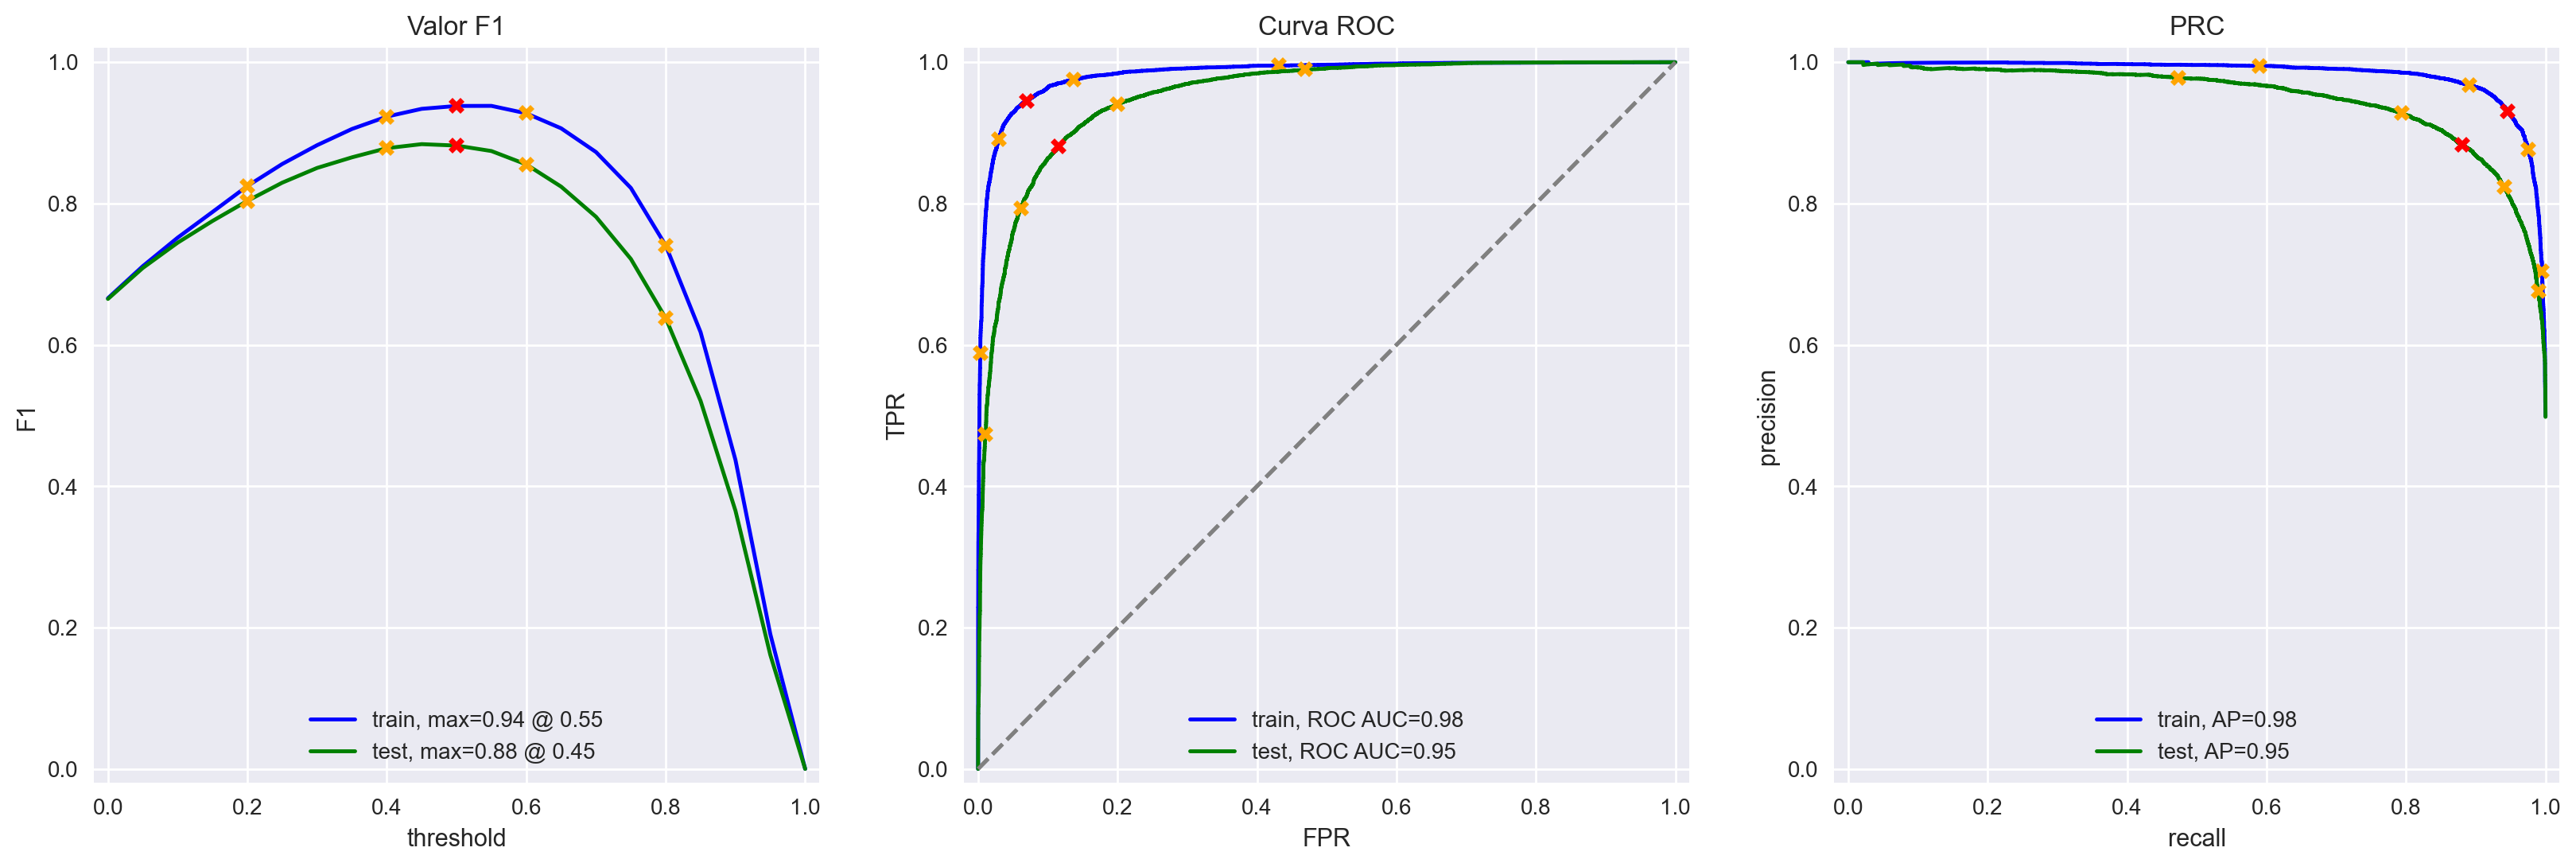

In [37]:
df_model_2 = evaluate_model(model_2, features_train_2, target_train, features_test_2, target_test)

Observaciones:
- En este caso las curvas de entrenamiento como de prueba marcan diferencias.
- Las curvas de la prediccion del conjunto de entrenamiento tienden a tener una mejor metrica que las de pruebas.
- El valor F1 en el conjunto de entrenamiento es de 0.94, mientras que para el de prueba es de 0.88, en ambos casos superar el valor minimo requerido, para un umbral de 0.45.
- El valor ROC para ambos casos supera el 95% lo cual implica que tiene una alta capacidad de distinguier entre clases positivas y negativas (en este caso las reseñas).
- La curva PRC muestra que la presicion del modelo es muy cercana a uno mientras la sensibilidad no supere 0.8 (esto se base a modificar el umbral que normalmente se mantiene en 0.5), posterior a eso, la presicion comienza a bajar.

In [38]:
# guardar datos 
df_models = pd.concat([df_models, transform_df_model(df_model_2, 'model_2')]).reset_index(drop=True)
df_models

,index,Accuracy,F1,APS,ROC AUC,model
0,train,0.49,0.49,0.50,0.50,model_1
1,test,0.50,0.50,0.50,0.50,model_1
2,train,0.94,0.94,0.98,0.98,model_2
3,test,0.88,0.88,0.95,0.95,model_2


### 3. Modelo spaCy, TF-IDF y LR

spaCy es utilizado para el procesamiento avanzado de lenguaje natural, mientras que TF-IDF se emplea para la extracción de características. Estas características se pasan a un modelo de regresión logística para la clasificación de sentimientos.

In [39]:
# Crear vetorizador
features_train_3, features_test_3 = vectorize_data(
    df_reviews_train['review_lemma'],
    df_reviews_test['review_lemma'],
    params_vectorizer={'stop_words': list(stop_words)})

In [40]:
# Entrenamiento de modelo
model_3 = LogisticRegression()
model_3.fit(features_train_3, target_train)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


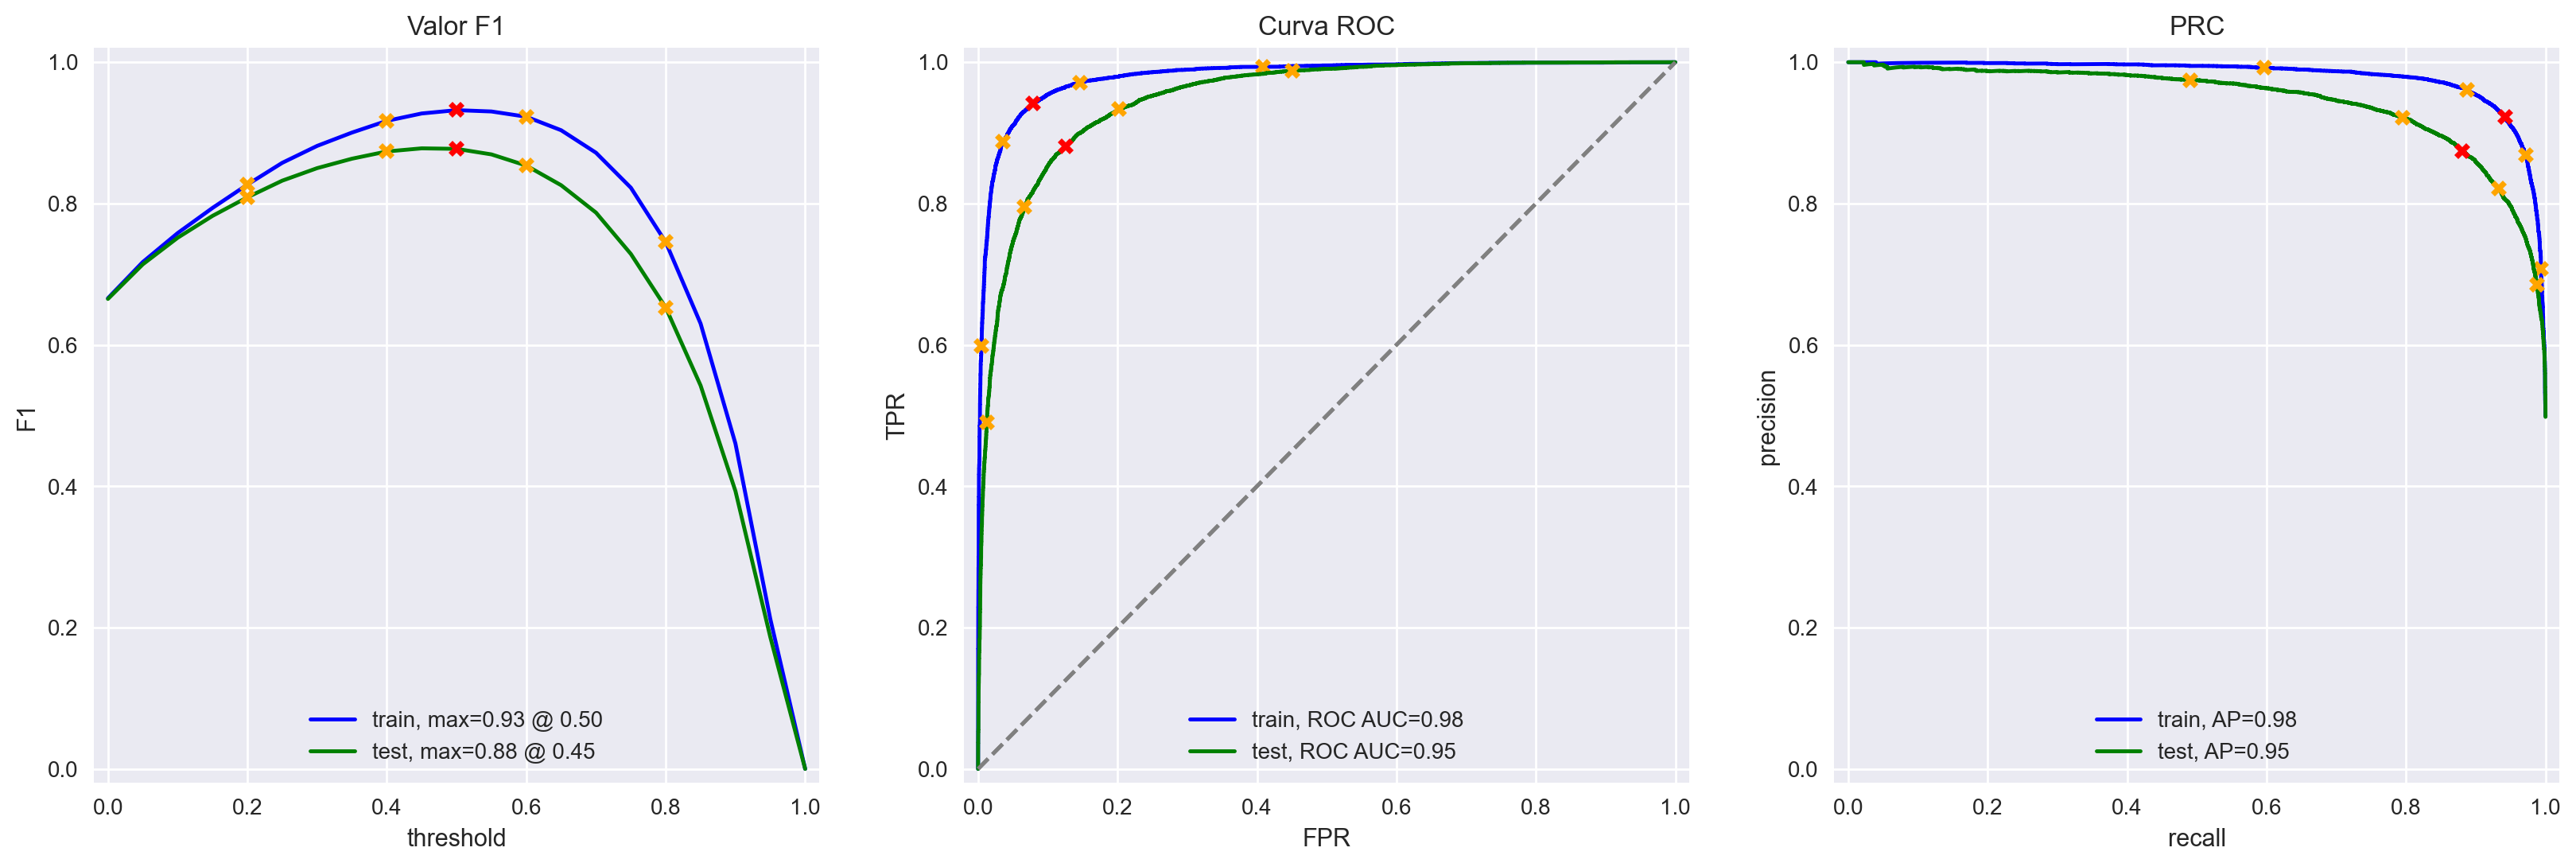

In [41]:
#Evaluar modelo
df_model_3 = evaluate_model(model_3, features_train_3, target_train, features_test_3, target_test)

Observaciones
- El comportamiento de los gráficos es muy similar al modelo anterior.
- El valor F1 maximo para el conjunto de pruebas alcanza su punto maximo de 0.88 con un umbral de 0.45.

In [42]:
# guardar datos 
df_models = pd.concat([df_models, transform_df_model(df_model_3, 'model_3')]).reset_index(drop=True)

### 4. Modelo spaCy, TF-IDF y LGBMClassifier

In [43]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [44]:
# Las caracteristica sa utilizar son las mismas utilizadas en el modelo anterior
features_train_4 = features_train_3
features_test_4 = features_test_3

In [45]:
# Entrenamiento de modelo
model_4 = LGBMClassifier(
    force_row_wise=True, 
    objetive='binary',
    random_state=STATE,
    verbose=-1)

param_grid_lgbm = {
    'max_depth': [10, 20],
    'num_leaves': [10, 50, 100],
    'n_estimators': [20, 50, 100],
    'learning_rate': [0.1, 0.5]
}

grid_cv_4 = GridSearchCV(
    estimator=model_4, 
    param_grid=param_grid_lgbm, 
    cv=3, scoring='f1', 
    )

grid_cv_4.fit(features_train_4, target_train)
best_params_4 = grid_cv_4.best_params_
print("Best Parameter:", best_params_4)

Best Parameter: {'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 10}


In [46]:
# Entrenamiento de modelo con hiperparametros seleccionados
model_4_bp = LGBMClassifier(
    force_row_wise=True, 
    objetive='binary',
    verbose=-1,
    random_state=STATE,
    **best_params_4
    )

model_4_bp.fit(features_train_3, target_train)

LGBMClassifier(force_row_wise=True, learning_rate=0.5, max_depth=10,
               num_leaves=10, objetive='binary', random_state=31415,
               verbose=-1)

          train  test
Accuracy   0.93  0.86
F1         0.93  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


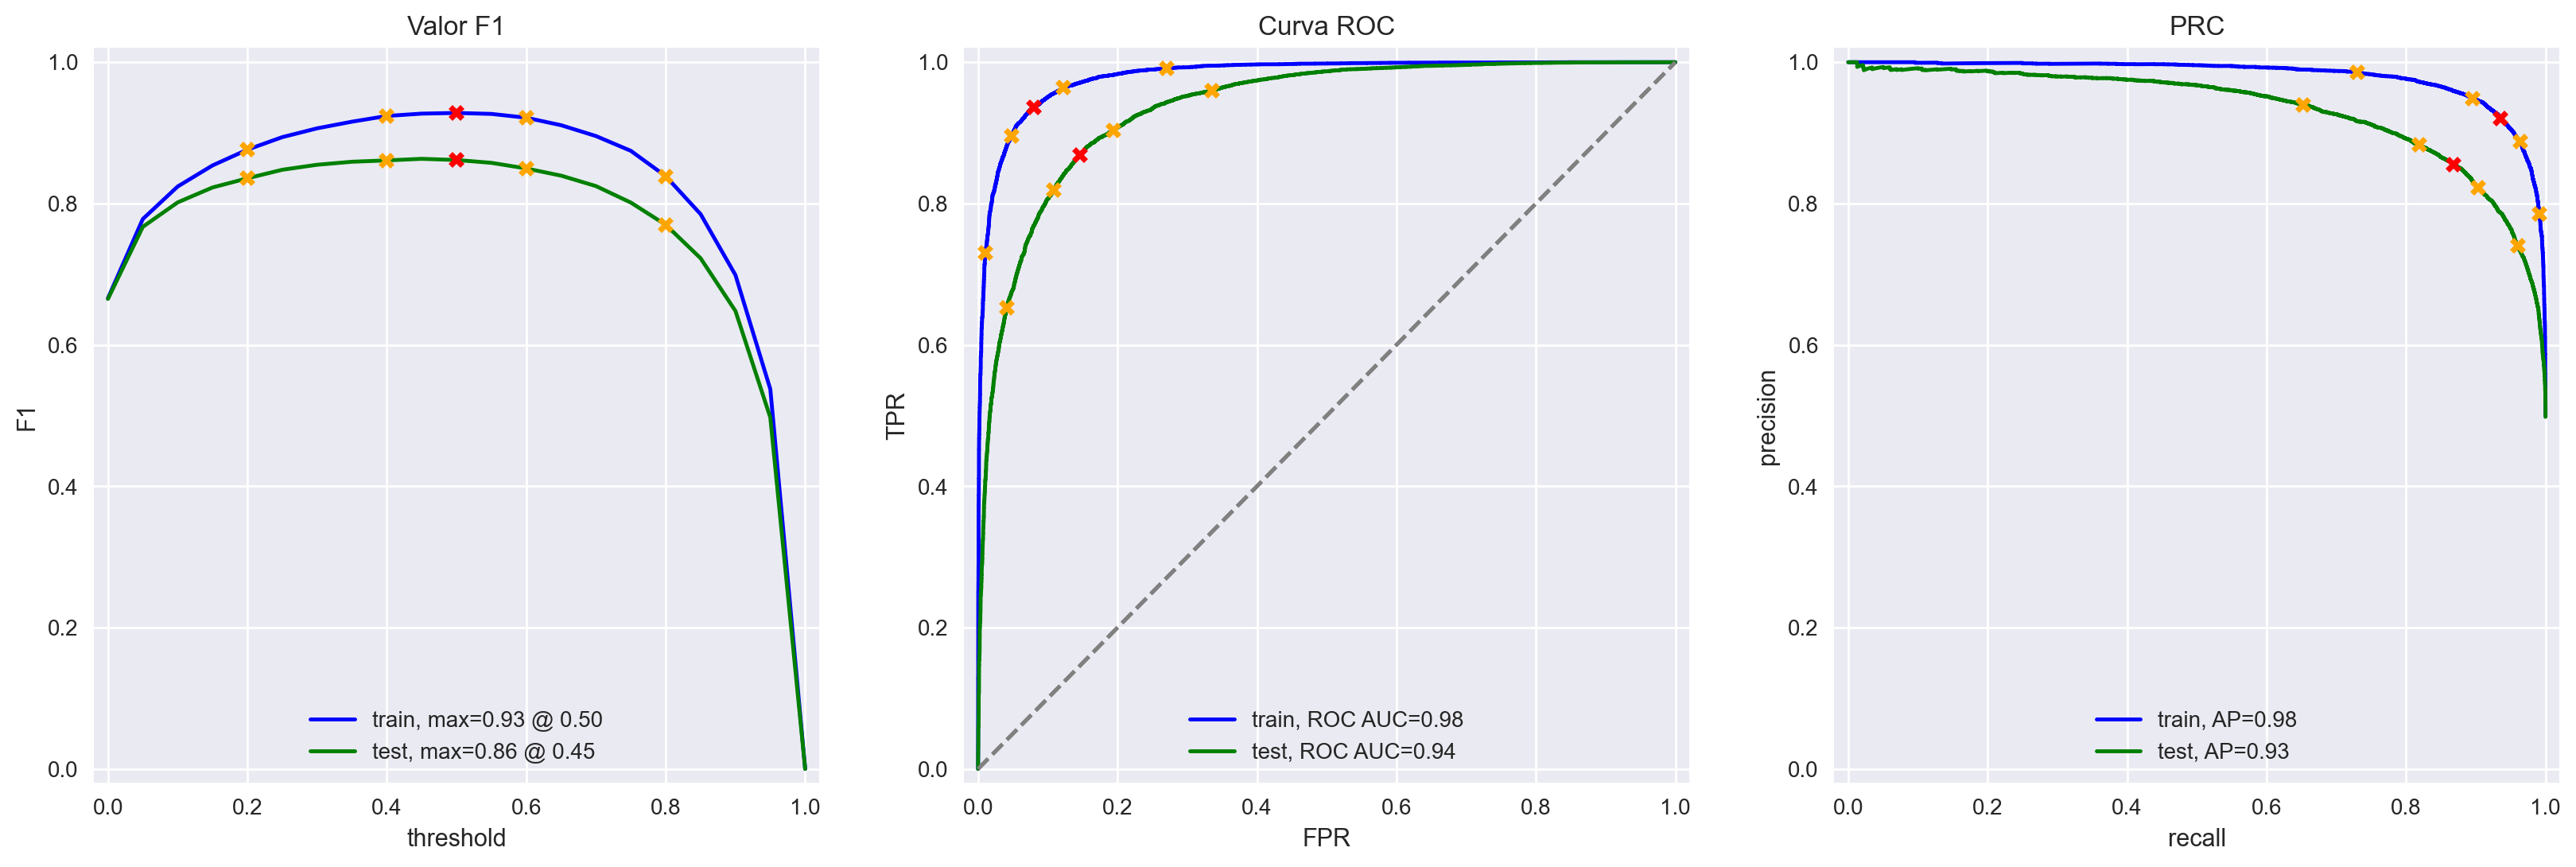

In [47]:
df_model_4 = evaluate_model(model_4_bp, features_train_4, target_train, features_test_4, target_test)

Observaciones
- El comportamiento de los gráficos es muy similar a los modelos anteriores.
- El valor F1 maximo para el conjunto de pruebas alcanza su punto maximo de 0.86 con un umbral de 0.45.

In [48]:
# guardar datos 
df_models = pd.concat([df_models, transform_df_model(df_model_4, 'model_4')]).reset_index(drop=True)

### 5. Modelo BERT

In [49]:
# Importacion de librerias
import math

import torch
import transformers
from tqdm.auto import tqdm 

In [50]:
# Preparacion de tokenizador y modelo para textos
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [51]:
# Funcion para Convertir textos en insertados

def BERT_text_to_embeddings(
    texts, 
    max_length=512, 
    batch_size=100, 
    force_device=None, 
    disable_progress_bar=False):
		
    ids_list = []
    attention_mask_list = []
		
    # texto a los ID de relleno de tokens junto con sus máscaras de atención
		
    for input_text in texts:
        ids = tokenizer.encode(
            input_text.lower(),
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
		    )
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
		
	# Seleccionar fuente de procesamiento
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
		
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
	# obtener insertados en lotes
    embeddings = []

    for i in tqdm(range(
		math.ceil(len(ids_list)/batch_size)), 
		disable=disable_progress_bar):
				
		# unión de vectores de ids (de tokens) a un tensor
        ids_batch = torch.LongTensor(
				ids_list[batch_size*i:batch_size*(i+1)]
		).to(device)
				
		# unión de vectores de máscaras de atención a un tensor
        attention_mask_batch = torch.LongTensor(
				attention_mask_list[batch_size*i:batch_size*(i+1)]
		).to(device)
				
		# Se utiliza para no usar gradiente, a menos que crees tu propio modelo
        with torch.no_grad():
            model.eval()
            batch_embeddings = model(
				input_ids=ids_batch, 
				attention_mask=attention_mask_batch
				)
		
		# Pasa los datos y la máscara al modelo para obtener insertados para el lote
		# batch_embeddings = model(ids_batch, attention_mask=attention_mask_batch)
				
		# convierte elementos de tensor a numpy.array con la función numpy()
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
    
    #Concatenar los insertados para obtener una matriz de caracteristicas
    return np.concatenate(embeddings)

In [52]:
# Obtencion de caracteristicas de entrenamiento
features_train_5 = BERT_text_to_embeddings(df_reviews_train['review'], force_device='cuda:0')

Uso del dispositivo cuda:0.


  0%|          | 0/238 [00:00<?, ?it/s]C:\Users\joaqu\AppData\Local\Temp\ipykernel_25628\2696684400.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  ids_batch = torch.LongTensor(
d:\projects\TripleTen\sprint_14\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 238/238 [08:10<00:00,  2.06s/it]


In [53]:
# Obtencion de caracteristicas de pruebas
features_test_5 = BERT_text_to_embeddings(df_reviews_test['review'], force_device='cuda:0')

Uso del dispositivo cuda:0.


100%|██████████| 235/235 [08:09<00:00,  2.08s/it]


In [54]:
# Busqueda de hiperparametros para el modelo
model_5 = LGBMClassifier(
    force_row_wise=True, 
    objetive='binary',
    random_state=STATE,
    verbose=-1)

param_grid_lgbm = {
    'max_depth': [10, 20],
    'num_leaves': [10, 50, 100],
    'n_estimators': [20, 50, 100],
    'learning_rate': [0.1, 0.5]
}

grid_cv = GridSearchCV(
    estimator=model_5, 
    param_grid=param_grid_lgbm, 
    cv=3, scoring='f1', 
    )

grid_cv.fit(features_train_5, target_train)

best_params_5 = grid_cv.best_params_
print("Best Parameter:", best_params_5)

Best Parameter: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 50}


In [55]:
# Entrenamiento del modelo con hiperparametros
model_5_bp = LGBMClassifier(
    force_row_wise=True, 
    objetive='binary',
    verbose=-1,
    random_state=STATE,
    **best_params_5
    )

model_5_bp.fit(features_train_5, target_train)

LGBMClassifier(force_row_wise=True, max_depth=20, num_leaves=50,
               objetive='binary', random_state=31415, verbose=-1)

          train  test
Accuracy   0.97  0.85
F1         0.97  0.85
APS        1.00  0.93
ROC AUC    1.00  0.93


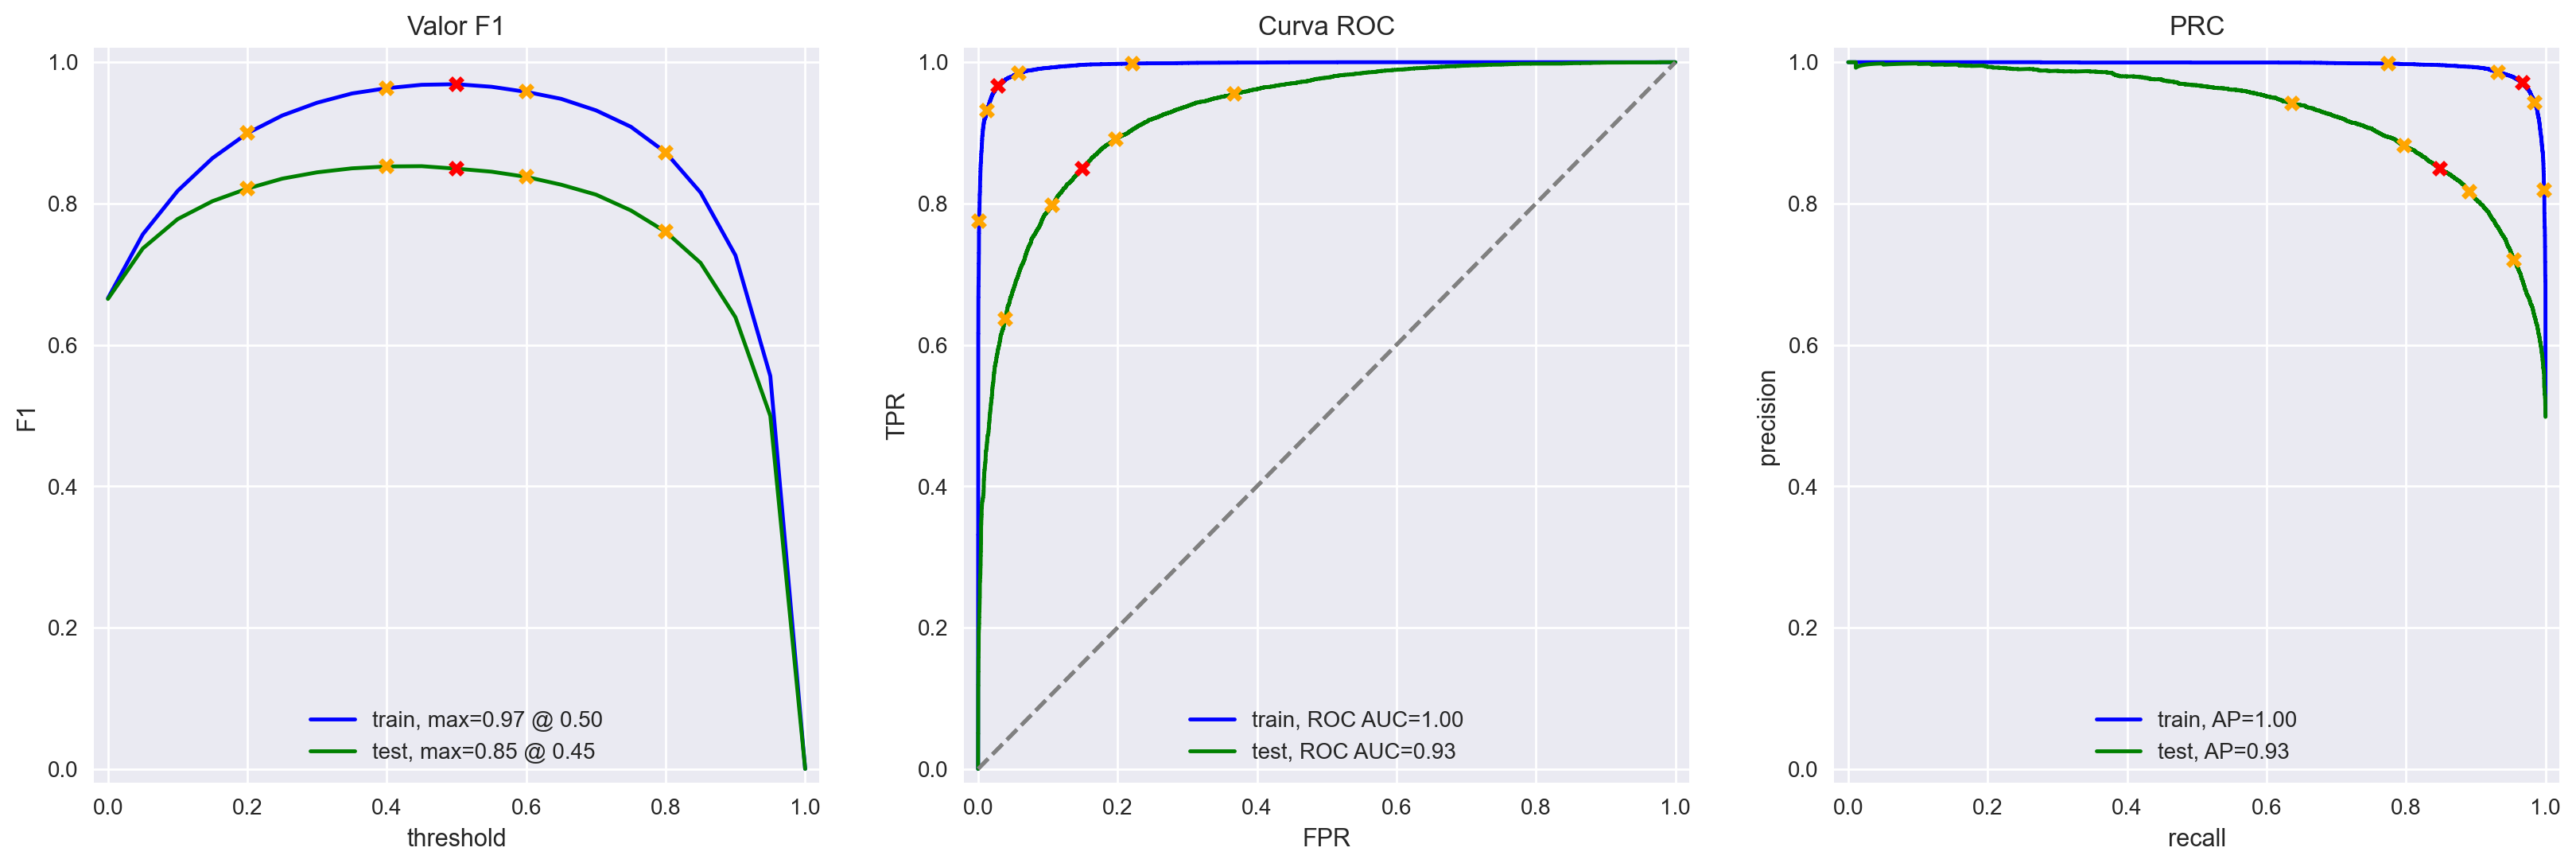

In [56]:
# Evaluación del modelo
df_model_5 = evaluate_model(model_5_bp, features_train_5, target_train, features_test_5, target_test)

Observaciones
- El comportamiento de los gráficos es muy similar al modelo anterior.
- El valor F1 maximo para el conjunto de pruebas alcanza su punto maximo de 0.85 con un umbral de 0.45.
- Se puede destacar que este modelo puede estar sobreajustado, debido a que las curvas relacionadas al conjunto de entrenamiento tanto para la curva ROC como para la curva PRC tienden a 1.

In [57]:
# guardar datos 
df_models = pd.concat([df_models, transform_df_model(df_model_5, 'model_5')]).reset_index(drop=True)

## Prueba con reseñas propias

Se crearán 10 reseñas, donde se especificará además si esta tiene una intencion positiva o negativa, para luego evaluar con los modelos ya entrenados y verificar sus metricas, se condierará un umbral de 0.45 debido a que para todos los modelos el F1 se obtuvo en un umbral de 0.45.

In [58]:
# Listado con reseñas propias

my_reviews = [
    'I really enjoyed the movie, the story is very well told and the ending was incredible.',
    'The CGI quality was horrible, everything was very dark and many things did not make sense.',
    'I loved the main characters, I almost cried at the end from the emotion.',
    'The movie had its good and bad moments, I was a little bored at the beginning but in the end I really enjoyed the story.',
    'It was a complete waste of money, it was all very absurd and made no sense.',
    'It was not what I expected from the movie, I had the wrong idea about the plot, or maybe I did not understand correctly what it was about.',
    'What a masterpiece! If you needed a nap, this is perfect. The plot is predictable and the characters are utterly forgettable.',
    'An absolute thrill! Perfect plot twists, eerie atmosphere, and well-timed scares. A must-watch for horror fans!',
    'Hilarious from start to finish! Great timing, witty dialogue, and lovable characters. A must-watch comedy gem!.',
    'A stunning fantasy epic! Rich world-building, captivating storyline, and breathtaking visuals. A must-watch for any fantasy lover!'
]

df_my_reviews = pd.DataFrame(my_reviews, columns=['review'])
df_my_reviews

,review
0,"I really enjoyed the movie, the story is very ..."
1,"The CGI quality was horrible, everything was v..."
2,"I loved the main characters, I almost cried at..."
3,"The movie had its good and bad moments, I was ..."
4,"It was a complete waste of money, it was all v..."
5,"It was not what I expected from the movie, I h..."
6,"What a masterpiece! If you needed a nap, this ..."
7,"An absolute thrill! Perfect plot twists, eerie..."
8,"Hilarious from start to finish! Great timing, ..."
9,"A stunning fantasy epic! Rich world-building, ..."


In [78]:
# Objetivos
target_my_reviews = pd.DataFrame([1,0,1,1,0,0,0,1,1,1], columns=['pos'])
target_my_reviews

,pos
0,1
1,0
2,1
3,1
4,0
5,0
6,0
7,1
8,1
9,1


In [60]:
# Normalizacion de datos
df_my_reviews['review_norm'] = df_my_reviews['review'].apply(lambda text: clear_text(text.lower()))
df_my_reviews['review_norm'].head()

0    i really enjoyed the movie the story is very w...
1    the cgi quality was horrible everything was ve...
2    i loved the main characters i almost cried at ...
3    the movie had its good and bad moments i was a...
4    it was a complete waste of money it was all ve...
Name: review_norm, dtype: object

In [61]:
# Lemmatizacion de datos
df_my_reviews['review_lemma'] = df_my_reviews['review'].apply(lambda text: lemmatize(clear_text(text.lower())))
df_my_reviews['review_lemma'].head()

0    I really enjoy the movie the story be very wel...
1    the cgi quality be horrible everything be very...
2    I love the main character I almost cry at the ...
3    the movie have its good and bad moment I be a ...
4    it be a complete waste of money it be all very...
Name: review_lemma, dtype: object

### Modelo 2

Modelo NLTK, TF-IDF, LR

In [70]:
# Crear vectorizador
features_train_2_mr, features_test_2_mr = vectorize_data(
    df_reviews_train['review_norm'],
    df_my_reviews['review_norm'],
    params_vectorizer={'stop_words': list(stop_words)})

In [71]:
# Prediccion eb funcion al modelo entrenado
predictions_2 = model_2.predict_proba(features_test_2_mr)[:, 1]

print('Valor F1 para modelo 2:')
print(metrics.f1_score(target_my_reviews, predictions_2>=0.45))

Valor F1 para modelo 2:
0.9090909090909091


### Modelo 3

Modelo spaCy, TF-IDF y LR

In [72]:
# Crear vectorizador
features_train_3_mr, features_test_3_mr = vectorize_data(
    df_reviews_train['review_lemma'],
    df_my_reviews['review_lemma'],
    params_vectorizer={'stop_words': list(stop_words)})

In [73]:
# Prediccion eb funcion al modelo entrenado
predictions_3 = model_3.predict_proba(features_test_3_mr)[:, 1]

print('Valor F1 para modelo 3:')
print(metrics.f1_score(target_my_reviews, predictions_3>=0.45))

Valor F1 para modelo 3:
0.9090909090909091


### Modelo 4

Modelo spaCy, TF-IDF y LGBMClassifier

In [74]:
# Se mantienen los features del modelo 3
features_test_4_mr = features_test_3_mr

In [75]:
# Prediccion eb funcion al modelo entrenado
predictions_4 = model_4_bp.predict_proba(features_test_4_mr)[:, 1]

print('Valor F1 para modelo 4:')
print(metrics.f1_score(target_my_reviews, predictions_4>=0.45))

Valor F1 para modelo 4:
0.9090909090909091


### Modelo 5

Modelo BERT

In [76]:
# Obtencion de caracteristicas de pruebas
features_test_5_mr = BERT_text_to_embeddings(df_my_reviews['review'], force_device='cuda:0')

Uso del dispositivo cuda:0.


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


In [77]:
# Prediccion eb funcion al modelo entrenado
predictions_5 = model_5_bp.predict_proba(features_test_5_mr)[:, 1]

print('Valor F1 para modelo 5:')
print(metrics.f1_score(target_my_reviews, predictions_5>=0.45))

Valor F1 para modelo 5:
0.9230769230769231


Observaciones:
- Todos los modelos fueron capaces de obtener un valor F1 superior a 0.9, siendo el modelo BERT el que tuvo mejor resultado con un valor F1 de 0.92

## Analisis de resultados

In [79]:
df_models

,index,Accuracy,F1,APS,ROC AUC,model
0,train,0.49,0.49,0.50,0.50,model_1
1,test,0.50,0.50,0.50,0.50,model_1
2,train,0.94,0.94,0.98,0.98,model_2
3,test,0.88,0.88,0.95,0.95,model_2
4,train,0.93,0.93,0.98,0.98,model_3
5,test,0.88,0.88,0.95,0.95,model_3
6,train,0.93,0.93,0.98,0.98,model_4
7,test,0.86,0.86,0.93,0.94,model_4
8,train,0.97,0.97,1.00,1.00,model_5
9,test,0.85,0.85,0.93,0.93,model_5


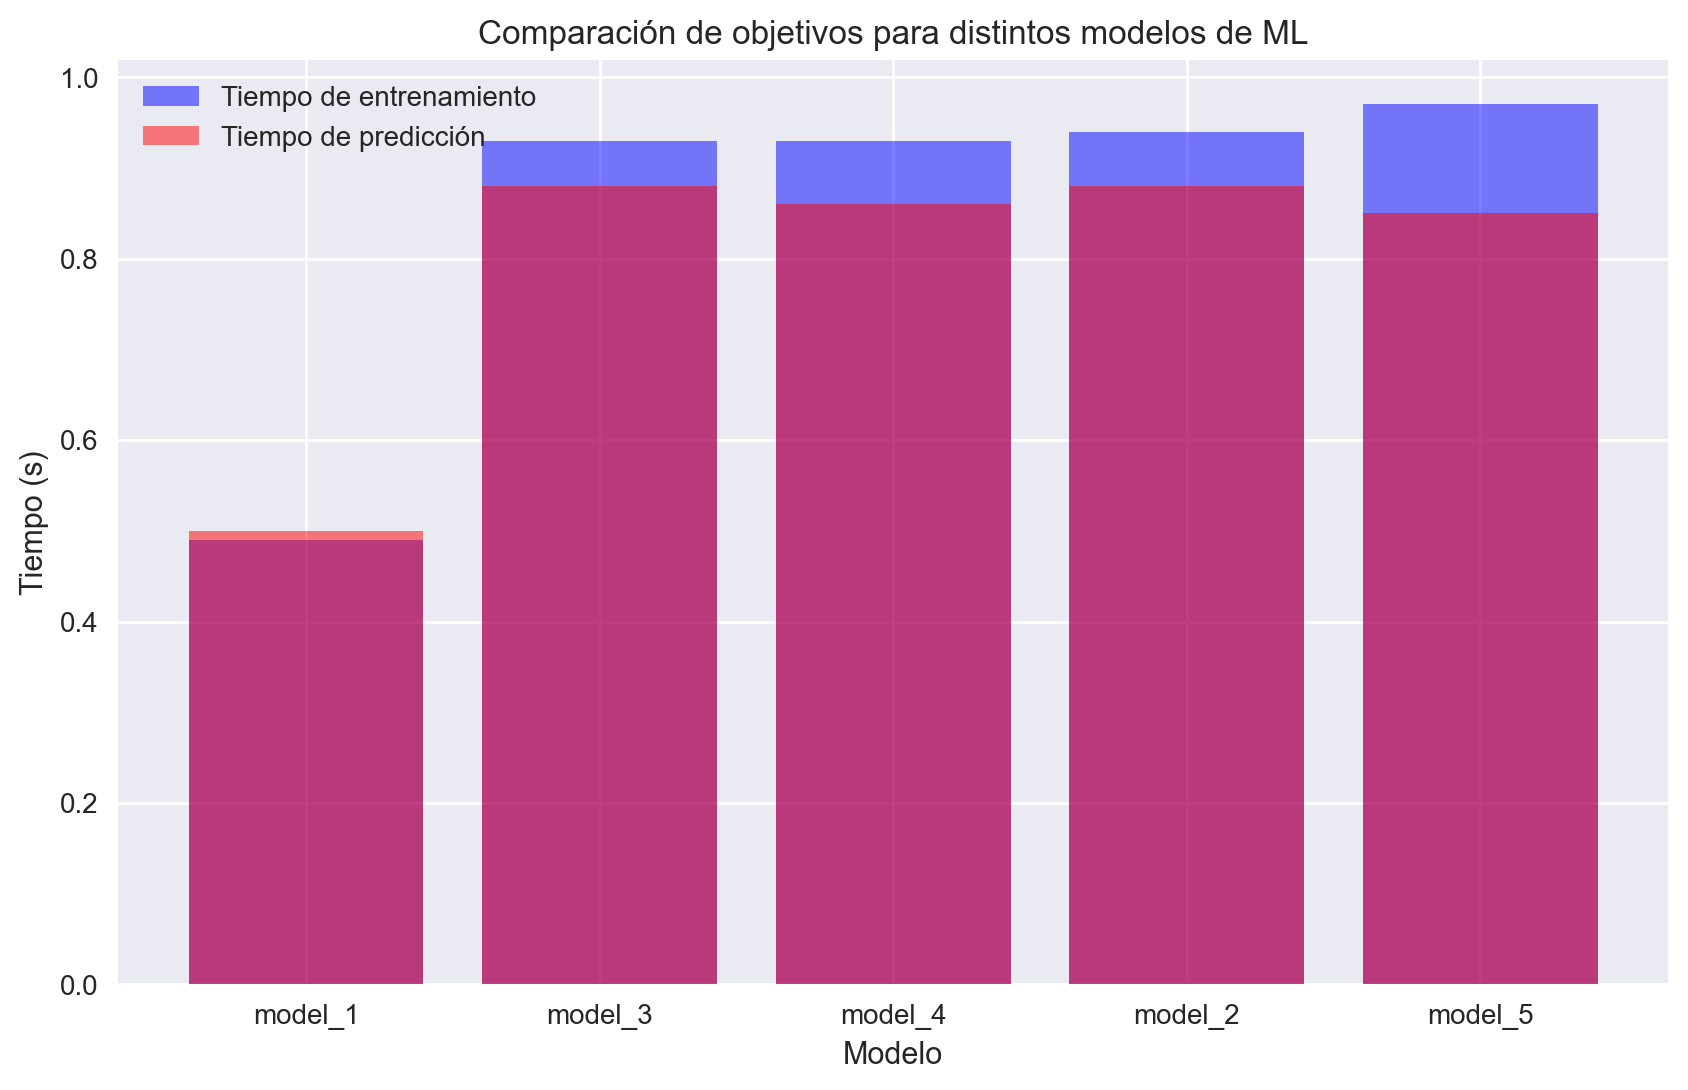

In [83]:
df_models = df_models.sort_values(by='F1', ascending=False)
df_models_train = df_models[df_models['index'] == 'train']
df_models_test = df_models[df_models['index'] == 'test']

plt.figure(figsize=(10, 6))

plt.bar(df_models_train['model'], df_models_train['F1'], color='blue', alpha=0.5, label='Tiempo de entrenamiento')
plt.bar(df_models_test['model'], df_models_test['F1'], color='red', alpha=0.5, label='Tiempo de predicción')
plt.title('Comparación de objetivos para distintos modelos de ML')
plt.ylabel('Tiempo (s)')
plt.xlabel('Modelo')
plt.legend(loc='upper left')



plt.show()

## Conclusiones